## Introduction to scRNA-seq

*Following are my notes from the online book [Single-cell best practices](https://www.sc-best-practices.org/preamble.html).*

**Sequencing:**

Sequencing, in general, is the process of deciphering the order of DNA nucleotides and is primarily used to unveil the genetic information that is carried by a specific DNA segment, a complete genome, or even a complex microbiome. DNA sequencing allows researchers to identify the location and function of genes and regulatory elements in the DNA molecule and the genome.

However, knowing the DNA sequence of an organism and the positions of its regulatory elements tells us very little about the dynamic and real-time operations of a cell. For example, by combining different mRNA splicing sites and exons from the same mRNA precursor, one gene can code for multiple proteins. This alternative splicing event is naturally occurring and commonly seen in eukaryotes; however, a variant could potentially result in a non-functional enzyme and an induced disease state. This is where RNA sequencing (RNA-Seq) comes into play.

Sequencing RNA allows scientists to obtain snapshots of cells, tissues or organisms at the time of sequencing in the form of expression profiles of genes. 

**Single-cell RNA sequencing:**

Bulk RNA-Seq results in cell-averaged expression profiles, which are generally easier to analyze, but also hide some of the complexity such as cell expression profile heterogeneity, which may help answer the question of interest. Some drugs or perturbations may affect only specific cell types or interactions between cell types.

**Transcript quantification step:**

Transcript quantification is the 'final' process of converting the raw data into an table of estimated transcript counts per gene per sample (for bulk-sequencing) or per cell (for single-cell sequencing).

Depending on the sequencing protocol, the resulting raw sequence file contains the cell-level information, commonly known as cell barcodes (CB), the unique molecule identifier (UMI), and the raw cDNA sequence (read sequence) generated from the molecule.

Beads tag the RNA content of individual cells with unique oligonucleotides, called cell barcodes (CBs), that are later sequenced along with the fragments of the cDNAs that are reversely transcribed from the RNA content. CB correction is done to correct for errors in barcoding.

After UMI resolution and count assignment step, we get  a matrix of transcript count (i.e. expression levels) of genes per cell.

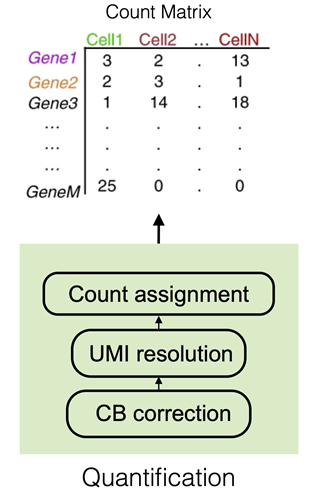\
*Final steps in data collection. Image from [Fig. 3.1](https://www.sc-best-practices.org/introduction/raw_data_processing.html#raw-proc-fig-overview) in the book.*

## Annotated data structure

The Count Matrix will be of the shape `number_observations` x `number_variables`. For scRNA-seq, observations are cellular barcodes and the variables are annotated genes; thast is, the count matrix shall be transposed. Over the course of an analysis the observations and variables of this matrix are annotated with computationally derived measurements (e.g. quality control metrics, or latent space embeddings) and prior knowledge (e.g. source donor or alternative gene identifier).

We will use AnnData to associate the data matrix with these annotations.

At its core, an AnnData object stores a sparse or dense matrix (the count matrix in the case of scRNA-Seq) in X. This matrix `X` has the dimensions of `obs_names` x `var_names` where the obs (=observations) correspond to the cells' barcodes and the var (=variables) correspond to the gene identifiers. This matrix X is surrounded by Pandas DataFrames `obs` and `var` which save annotations of cells and genes respectively.

Further, AnnData saves whole matrices of calculations for the observations (`obsm`) or variables (`varm`) with the corresponding dimensions. Graph like structures which associate cells with cells or genes with genes are usually saved in `obsp` and `varp`. Any other unstructured data which does not fit any other slot is saved as unstructured data in uns. It is further possible to store more values of X in `layers`. Use cases for this are for example the storage of raw, unnormalized count data in a counts layer and the normalized data in the unnamed default layer.

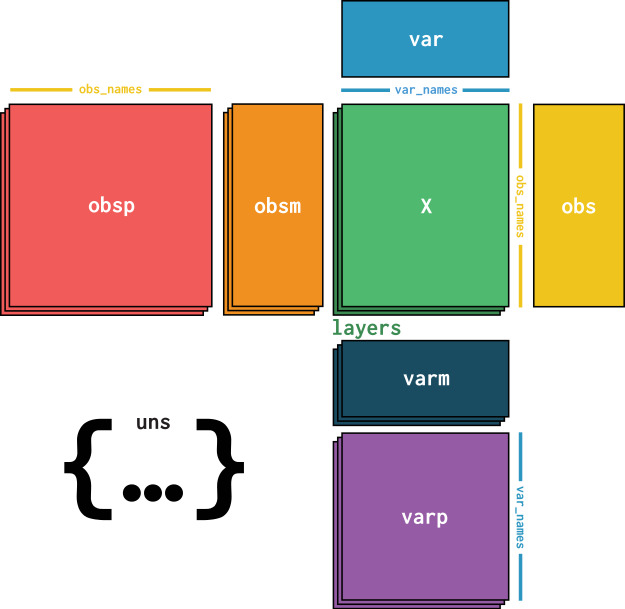\
*AnnData Data Structure. Image from [Fig. 4.1](https://www.sc-best-practices.org/introduction/analysis_tools.html#anndata-fig) in the book.*



**AnnData Example:**

Let us create a simple AnnData object with sparse count information which may for example represent gene expression counts.

In [1]:
import numpy as np
import pandas as pd
import anndata as ad # installation: pip3 install anndata
from scipy.sparse import csr_matrix

In [2]:
np.random.seed(42)
# Count matrix of 10 genes across 5 cells
count_matrix = csr_matrix(np.random.poisson(1, size=(10, 5)), dtype=np.float32)
count_matrix.toarray()

array([[1., 2., 0., 0., 3.],
       [2., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [3., 0., 1., 0., 1.],
       [1., 1., 1., 0., 5.],
       [0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 2.],
       [0., 3., 0., 0., 0.],
       [2., 0., 0., 0., 3.]], dtype=float32)

In [3]:
# initialize an AnnData object; note the transpose 
adata = ad.AnnData(count_matrix).T
adata.X

<5x10 sparse matrix of type '<class 'numpy.float32'>'
	with 24 stored elements in Compressed Sparse Column format>

In [4]:
# indexing the obs and var axes
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names)

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4'], dtype='object')


In [5]:
# adding aligned metadata on obs/var, i.e. cell/gene level
ct = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs["cell_type"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
adata.obs

,cell_type
Cell_0,B
Cell_1,Monocyte
Cell_2,T
Cell_3,Monocyte
Cell_4,B


In [6]:
# subsetting using metadata
# slicing and masking of adata object behaves similarly to df object in Pandas
adata2 = adata[adata.obs.cell_type == "B"]
adata2

View of AnnData object with n_obs × n_vars = 2 × 10
    obs: 'cell_type'

In [7]:
# adding matrix metadata
# metadata such as a UMAP embedding has multiple dimensions to it
# they go in .obsm/.varm attributes
adata.obsm["X_umap"] = np.random.normal(0, 1, size=(adata.n_obs, 2))
adata

AnnData object with n_obs × n_vars = 5 × 10
    obs: 'cell_type'
    obsm: 'X_umap'

In [8]:
# unstructured metadata
adata.uns["dict"] = {0:'MT', 1:'RM', 2:'HB', 3:'CD'}
adata.uns

OrderedDict([('dict', {0: 'MT', 1: 'RM', 2: 'HB', 3: 'CD'})])

In [9]:
# different forms of our original core data
adata.layers["log_transformed"] = np.log1p(adata.X)
adata.to_df(layer="log_transformed")

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9
Cell_0,0.693147,1.098612,0.000000,0.000000,1.386294,0.693147,0.000000,0.693147,0.000000,1.098612
Cell_1,1.098612,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,1.386294,0.000000
Cell_2,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000
Cell_3,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000
Cell_4,1.386294,0.693147,0.693147,0.000000,0.693147,1.791759,0.693147,1.098612,0.000000,1.386294


## Data analysis with Scanpy

**Importing data**

In [10]:
import scanpy as sc

# Data Source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5226574
# Data Title: Healthy human lung tissue snRNA-seq
adata = sc.read_csv('data\scRNA-Seq\GSM5226574_C51ctr_raw_counts.csv').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [11]:
print(adata.obs.index) # cell barcodes
print(adata.var.index) # gene labels

Index(['TAGGTACCATGGCCAC-1_1', 'ATTCACTGTAACAGGC-1_1', 'TAACTTCCAACCACGC-1_1',
       'TTGGGTACACGACAAG-1_1', 'AGGCCACAGAGTCACG-1_1', 'CACTGAAGTCGAAGCA-1_1',
       'ACTGATGTCTGCACCT-1_1', 'TTACCGCCACTCAGAT-1_1', 'TTGGTTTTCCTAGCTC-1_1',
       'TGGGAAGTCAGTGATC-1_1',
       ...
       'AAGTCGTGTGTGAATA-1_1', 'GTCGTTCTCCAAGGGA-1_1', 'GTTTGGATCGGCCTTT-1_1',
       'GTACAGTCACGTATAC-1_1', 'TCATGCCCAAGAGGTC-1_1', 'CGCCATTGTTTGCCGG-1_1',
       'CACTGGGGTCTACGTA-1_1', 'CATACTTGTAGAGGAA-1_1', 'TTTGGTTTCCACGGAC-1_1',
       'ATGCATGAGTCATGAA-1_1'],
      dtype='object', length=6099)
Index(['AL627309.1', 'AL627309.5', 'AL627309.4', 'AL669831.2', 'LINC01409',
       'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6',
       ...
       'AC087190.2', 'AC136428.1', 'AC019183.1', 'AC105094.1', 'AC010485.1',
       'VN1R2', 'AL031676.1', 'SMIM34A', 'AL050402.1', 'AL445072.1'],
      dtype='object', length=34546)


**Preprocessing**

In [12]:
# saving count data
adata.layers["counts"] = adata.X.copy()

# normalizing to median total counts
sc.pp.normalize_total(adata)

# logarithmize the data
sc.pp.log1p(adata)

**Dimensionality Reduction**

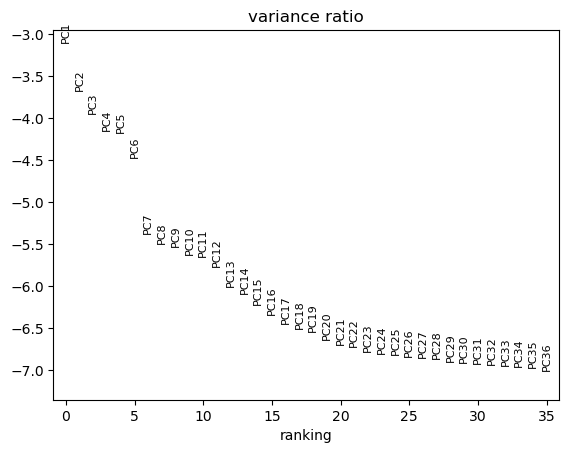

In [13]:
# Reduce the dimensionality of the data by running principal component analysis (PCA) tool
# which reveals the main axes of variation
sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=35, log=True)

This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells. It looks like 25 PCs should be fine.

In [14]:
adata.varm['PCs'].shape

(34546, 50)

In [15]:
adata.obsm['X_pca'].shape

(6099, 50)

**Visualization of cell-groups**

In [21]:
from sklearn.neighbors import KNeighborsTransformer
transformer = KNeighborsTransformer(n_neighbors=15)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=25, transformer=transformer)

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE in SciKit-Learn. t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. 

In [22]:
# embedding the graph in two dimensions using UMAP
sc.tl.umap(adata)

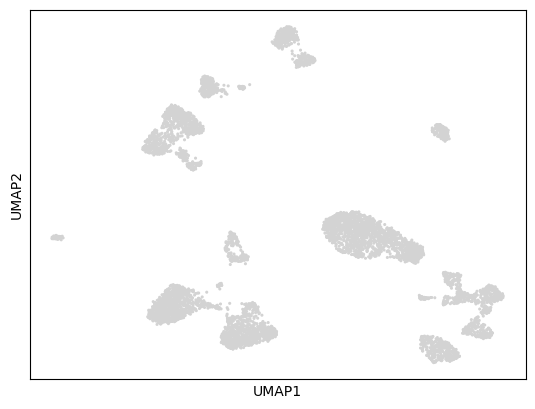

In [23]:
# visualize 
sc.pl.umap(adata)

In [24]:
adata # note the addition of umap and X_umap

AnnData object with n_obs × n_vars = 6099 × 34546
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

**Clustering to mark cell-groups**

In [25]:
adata.obsm['X_umap']

array([[ 19.290073 , -10.259718 ],
       [ 17.594595 ,  -9.632188 ],
       [ 21.201498 ,  -7.98914  ],
       ...,
       [ 11.802208 ,   3.4458518],
       [  6.80553  ,  19.239855 ],
       [ -2.001381 ,  -4.2816577]], dtype=float32)

In [42]:
from sklearn.cluster import KMeans

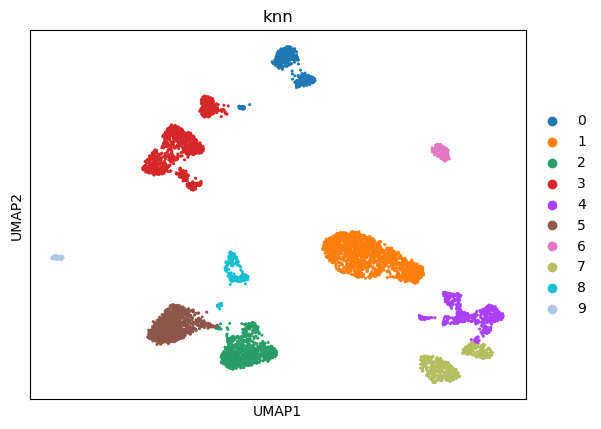

In [43]:
knn = KMeans(n_clusters=10, n_init=20, random_state=2)
knn.fit(adata.obsm['X_umap'])
adata.obs['knn'] = pd.Categorical(knn.labels_)
sc.pl.umap(adata, color='knn')